In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
from IPython.display import display, clear_output
import os 
from pathlib import Path
import uproot
import pandas as pd

In [2]:
#Using a simualted phantom and sinogram

'''true_object = shepp_logan_phantom()
activity_level = 0.1
true_object = rescale(activity_level * true_object, 0.5)

#Forward project true object to generate simulated sinogram data 

azi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles
sinogram = radon(true_object, azi_angles, circle=False)'''


'true_object = shepp_logan_phantom()\nactivity_level = 0.1\ntrue_object = rescale(activity_level * true_object, 0.5)\n\n#Forward project true object to generate simulated sinogram data \n\nazi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles\nsinogram = radon(true_object, azi_angles, circle=False)'

In [3]:
#Using data from GATE

# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / "output"
if (not folder.is_dir()):
    print(f"ERROR: {folder} is not a folder.")
print(f"The Current Working Directory (CWD) is {cwd}")
print(f"The output folder is {folder}")

filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)

# print the list of trees
for t in f:
    print(f'Tree {t}')

# get the first tree and print the branches
hits = f['Singles1']

arrays = hits.arrays(["PostPosition_X", "PostPosition_Y", "PostPosition_Z", "TotalEnergyDeposit",  "GlobalTime", "LocalTime", "PreStepUniqueVolumeID"], library="np")

# Convert to DataFrame manually
df = pd.DataFrame({
    "PostPosition_X": arrays["PostPosition_X"],
    "PostPosition_Y": arrays["PostPosition_Y"],
    "PostPosition_Z": arrays["PostPosition_Z"],
    "TotalEnergyDeposit": arrays["TotalEnergyDeposit"],
    "GlobalTime": arrays["GlobalTime"],
    "LocalTime": arrays["LocalTime"],
    "PreStepUniqueVolumeID": arrays["PreStepUniqueVolumeID"]
})

print(f'Number of hits : {hits.num_entries}')
for b in hits:
    print(f'Branch {b.name}')

df.head()
print(df.shape)

The Current Working Directory (CWD) is /Users/jemmabagg/Documents/Masters/picoPET-sim
The output folder is /Users/jemmabagg/Documents/Masters/picoPET-sim/output
Tree Hits;1
Tree Singles1;1
Tree Singles2;1
Tree Singles3;1
Tree Singles4;1
Tree Singles5;1
Number of hits : 2723471.0
Branch PostPosition_X
Branch PostPosition_Y
Branch PostPosition_Z
Branch TotalEnergyDeposit
Branch PreStepUniqueVolumeID
Branch GlobalTime
Branch LocalTime
(2723471, 7)


In [4]:
def find_coincidences(df: pd.DataFrame, time_window: float) -> pd.DataFrame:
    """
    Find photon coincidences within a given time window.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing photon measurements with the columns:
                           ["PostPosition_X", "PostPosition_Y", "PostPosition_Z",
                            "TotalEnergyDeposit", "GlobalTime", "LocalTime"].
        time_window (float): Maximum allowed time difference between photon pairs.
        
    Returns:
        pd.DataFrame: DataFrame where each row represents a coincidence pair.
                      The columns are the original attributes suffixed with _1 and _2.
    """
    # Sort the dataframe by GlobalTime for an efficient sliding-window search.
    df_sorted = df.sort_values("GlobalTime").reset_index(drop=True)
    times = df_sorted["GlobalTime"].values
    energies = df_sorted["TotalEnergyDeposit"]
    n = len(df_sorted)
    coincidences = []

    # Define energy window
    energy_lower = 0.511 - 0.030
    energy_upper = 0.511 + 0.030

    #With energy limit
    '''for i in range(n):
        j = np.searchsorted(times, times[i] + time_window, side='right')

        if energy_lower <= energies[i] <= energy_upper:
            for k in range(i + 1, j):
                if energy_lower <= energies[k] <= energy_upper:
                    pair = {}
                    for col in df_sorted.columns:
                        pair[f"{col}_1"] = df_sorted.iloc[i][col]
                        pair[f"{col}_2"] = df_sorted.iloc[k][col]

                    pair["TOF_Difference"] = df_sorted.iloc[k]["GlobalTime"] - df_sorted.iloc[i]["GlobalTime"]
                    coincidences.append(pair)'''
    
    #Without energy cut
    for i in range(n):
        j = np.searchsorted(times, times[i] + time_window, side='right')

        
        for k in range(i + 1, j):
            pair = {}
            for col in df_sorted.columns:
                pair[f"{col}_1"] = df_sorted.iloc[i][col]
                pair[f"{col}_2"] = df_sorted.iloc[k][col]

            pair["TOF_Difference"] = df_sorted.iloc[k]["GlobalTime"] - df_sorted.iloc[i]["GlobalTime"]
            coincidences.append(pair)


    
    return pd.DataFrame(coincidences)

In [5]:
time_window = 1.5  # example time window value
coincidences_df = find_coincidences(df, time_window)
print(coincidences_df.head())
print("Number of coincidences =  " + str(coincidences_df.shape[0]))

   PostPosition_X_1  PostPosition_X_2  PostPosition_Y_1  PostPosition_Y_2  \
0         -7.500000         63.374903       -147.500000        133.402105   
1        -46.745071        147.500000        140.290407          4.500000   
2         46.745071       -137.994306       -140.290407        -52.288348   
3        136.846256        107.480231         55.059987        101.116270   
4         52.288348        134.550156        137.994306         60.603264   

   PostPosition_Z_1  PostPosition_Z_2  TotalEnergyDeposit_1  \
0               7.5              10.5              0.036650   
1             -10.5              10.5              0.399195   
2               1.5               1.5              0.305800   
3               7.5               1.5              0.510999   
4              -1.5              -7.5              0.253951   

   TotalEnergyDeposit_2  GlobalTime_1  GlobalTime_2  LocalTime_1  LocalTime_2  \
0              0.145227   2552.398462   2553.405795     0.647437     0.390388

In [6]:
#Defining the 3D Voxel grid

vox_size = 2 # Defining voxel size (mm)
volume_mm = (300, 300, 32)

num_voxels = tuple(int(length / vox_size) for length in volume_mm) # (150, 150, 16)

voxel_grid = np.ones(num_voxels, dtype=np.float32)
#print(voxel_grid)

voxel_origin_mm = np.array([ 
    -volume_mm[0] / 2 + vox_size, 
    -volume_mm[1] / 2 + vox_size,
    -volume_mm[2] / 2 + vox_size
]) #centres the voxel grid around (0, 0, 0) in world coordinates

time_threshold_ns = 0.7 #chose this because it should be the max time difference if a decay occurs at the circumference of the r = 100mm circle
#ensures only physically plausible pairs are considered

##Loop over LORs and find interesting voxels


In [7]:
#Function to sample along LOR - find out which voxels a LOR goes through
'''def get_voxel_indices_along_lor(p1, p2, voxel_origin_mm, vox_size, grid_shape, num_samples=100):
    
    Sample points along the LOR from p1 to p2, map them to voxel indices.
    
    points = np.linspace(p1, p2, num_samples)

    voxel_indices = ((points - voxel_origin_mm) / vox_size).astype(int) #voxel index for each sampled point
    
    in_bounds = np.all((voxel_indices>=0) & (voxel_indices< np.array(grid_shape)), axis=1) #checks whether voxel index is within bounds of voxel grid
    valid_indices = voxel_indices[in_bounds]

    unique_voxel_indices = {tuple(idx) for idx in valid_indices}

    return unique_voxel_indices '''


'def get_voxel_indices_along_lor(p1, p2, voxel_origin_mm, vox_size, grid_shape, num_samples=100):\n    \n    Sample points along the LOR from p1 to p2, map them to voxel indices.\n    \n    points = np.linspace(p1, p2, num_samples)\n\n    voxel_indices = ((points - voxel_origin_mm) / vox_size).astype(int) #voxel index for each sampled point\n    \n    in_bounds = np.all((voxel_indices>=0) & (voxel_indices< np.array(grid_shape)), axis=1) #checks whether voxel index is within bounds of voxel grid\n    valid_indices = voxel_indices[in_bounds]\n\n    unique_voxel_indices = {tuple(idx) for idx in valid_indices}\n\n    return unique_voxel_indices '

In [8]:
#Function to sample along LOR - find out which voxels a LOR goes through and also weight it based on how much of the voxel it passes through

def get_voxel_indices(p1, p2, origin, voxel_size, grid_shape):

    '''This function computes which voxels the LOR intersects with and how far the LOR travels in each voxel'''

    #Convert the start and end points form mm into voxel space
    p1_voxel = (p1 - origin) / voxel_size
    p2_voxel = (p2 - origin) / voxel_size

    #Define LOR direction and total length
    direction = p2_voxel - p1_voxel
    length_total = np.linalg.norm(direction)
    if length_total == 0:
        return []
    
    #Normalise the direction 
    direction_unit = direction / length_total

    #Prepare voxel grid and start at the correct voxel 
    nx, ny, nz = grid_shape
    current_voxel = np.floor(p1_voxel).astype(int)

    voxels = []
    t_max = np.zeros(3)
    t_delta = np.zeros(3)
    step = np.zeros(3, dtype=int)

    for i in range(3):
        if direction_unit[i] > 0:
            step[i] = 1
            next_voxel_boundary = (current_voxel[i] + 1) * 1.0
        else:
            step[i] = -1
            next_voxel_boundary = current_voxel[i] * 1.0

        if direction_unit[i] != 0:
            t_max[i] = (next_voxel_boundary - p1_voxel[i]) / direction_unit[i]
            t_delta[i] = abs(1.0 / direction_unit[i])
        else:
            t_max[i] = np.inf
            t_delta[i] = np.inf
            
    t = 0.0
    while t <= length_total:
        i, j, k = current_voxel
        if 0 <= i < nx and 0 <= j < ny and 0 <= k < nz:
            t_next = min(t_max)
            path_length = (t_next - t) * np.linalg.norm(voxel_size * direction_unit)
            voxels.append((i, j, k, path_length))
        else:
            break  # outside grid

        # Advance to next voxel
        axis = np.argmin(t_max)
        t = t_max[axis]
        t_max[axis] += t_delta[axis]
        current_voxel[axis] += step[axis]

    return voxels



In [9]:
#Creating an empty sensitivity mao
measured_dat = np.zeros_like(voxel_grid)

# Loop over your actual LORs (you can use a sample first)
for _, row in coincidences_df.iterrows():  # small sample to test
    # Get photon positions in mm
    p1 = np.array([row["PostPosition_X_1"], row["PostPosition_Y_1"], row["PostPosition_Z_1"]])
    p2 = np.array([row["PostPosition_X_2"], row["PostPosition_Y_2"], row["PostPosition_Z_2"]])

    # Get which voxels this LOR touches
    voxels_hit = get_voxel_indices(p1, p2, voxel_origin_mm, vox_size, voxel_grid.shape)

    # Increment each voxel hit
    for (i, j, k, l) in voxels_hit:
        measured_dat[i, j, k] += l

/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

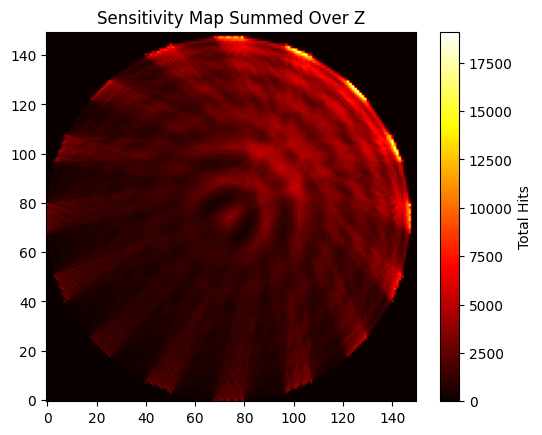

In [10]:
#Sensitivity map, shows how often voxel j is seen by all LORs

plt.imshow(np.sum(measured_dat, axis=2).T, cmap='hot', origin='lower')
plt.title("Sensitivity Map Summed Over Z")
plt.colorbar(label="Total Hits")

Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 10
Starting iteration 11
Starting iteration 12
Starting iteration 13
Starting iteration 14
Starting iteration 15
Starting iteration 16
Starting iteration 17
Starting iteration 18
Starting iteration 19
Starting iteration 20


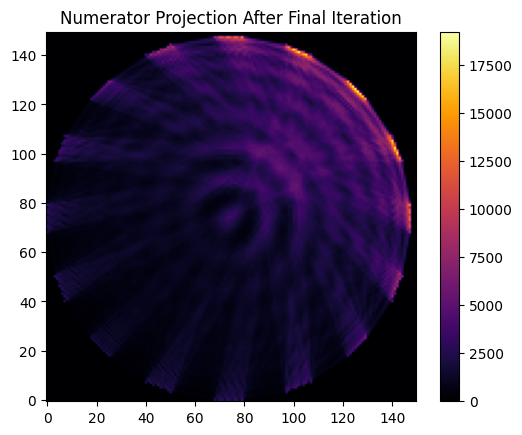

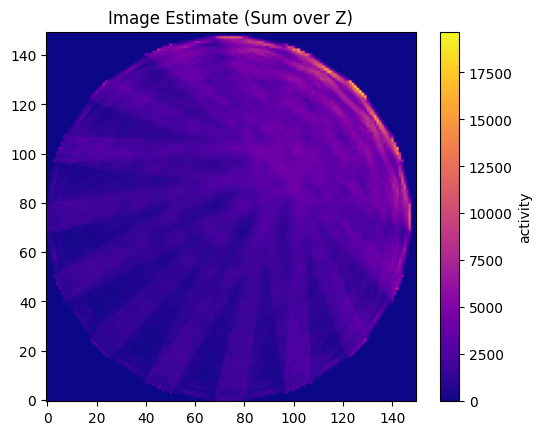

In [11]:
from scipy.ndimage import gaussian_filter

# --- Parameters ---
num_iterations = 20
epsilon = 1e-6  # small constant to avoid division by 0

# --- Initialize ---
image_estimate = np.ones_like(voxel_grid)
#image_estimate /= np.sum(image_estimate)  # Option A: normalize initial guess

#getting sens map to normalise - A^T1
sens = np.zeros_like(image_estimate)

for _, row in coincidences_df.iterrows():
    p1 = np.array([row["PostPosition_X_1"], row["PostPosition_Y_1"], row["PostPosition_Z_1"]])
    p2 = np.array([row["PostPosition_X_2"], row["PostPosition_Y_2"], row["PostPosition_Z_2"]])

    voxels_hit = get_voxel_indices(p1, p2, voxel_origin_mm, vox_size, voxel_grid.shape)

    for (i, j, k, l) in voxels_hit:
        sens[i,j,k] += l 


for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}")
    numerator = np.zeros_like(voxel_grid)

    for _, row in coincidences_df.iterrows():
        p1 = np.array([row["PostPosition_X_1"], row["PostPosition_Y_1"], row["PostPosition_Z_1"]])
        p2 = np.array([row["PostPosition_X_2"], row["PostPosition_Y_2"], row["PostPosition_Z_2"]])

        voxels_hit = get_voxel_indices(p1, p2, voxel_origin_mm, vox_size, voxel_grid.shape)

        if not voxels_hit:
            continue

        forward_sum = sum(image_estimate[i, j, k] * l for (i, j, k, l) in voxels_hit) + epsilon #forward project x^k
        measured_val = sum(measured_dat[i, j, k] * l for (i, j, k, l) in voxels_hit)

        correction = measured_val / (forward_sum) # m / Ax^k

        for (i, j, k, l) in voxels_hit: #backproject: A^T (1 / Ax^k)
            numerator[i, j, k] += correction * l

    ratio = numerator / (sens + epsilon) #normalise: 1/A^T1 * A^T(1/Ax^k)
    image_estimate = image_estimate * ratio # getting x^(k+1)


    # DEBUG: Show numerator projection after final iteration
    if iteration == num_iterations - 1:
        projection_numerator = np.sum(numerator, axis=2)
        plt.imshow(projection_numerator.T, cmap='inferno', origin='lower')
        plt.title("Numerator Projection After Final Iteration")
        plt.colorbar()
        plt.show()

         # Plot final image estimate
        projection_image = np.sum(image_estimate, axis=2)
        plt.imshow(projection_image.T, cmap='plasma', origin='lower')
        plt.title("Image Estimate (Sum over Z)")
        plt.colorbar(label="activity")
        plt.show()

In [12]:
def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180,
                     bins_tof: int = 50, tof_resolution: float = 300e-12, use_tof: bool = False):
    """
    Compute the sinogram from coincidence pairs.

    Each line-of-response (LOR) is parameterized by:
      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))
      - r: the perpendicular distance from the origin to the LOR.

    Parameters:
      coincidences_df: DataFrame with coincidence pairs, containing columns:
         'PostPosition_X_1', 'PostPosition_Y_1',
         'PostPosition_X_2', 'PostPosition_Y_2'.
      bins_theta: Number of bins for theta (angles in degrees).
      bins_r: Number of bins for r (distance).
      bins_tof: Number of bins for TOF (if use_tof=True).
      tof_resolution: Detector timing resolution in seconds (e.g., 300 ps).
      use_tof: Whether to include TOF binning.

    Returns:
      sinogram: 2D numpy array (shape: [bins_r, bins_theta]).
      theta_centers: 1D array of theta bin centers (in degrees).
      r_edges: 1D array of r bin edges.
    """
    #Plotting the TOF 3D Sinogram
    thetas = []
    rs = []
    tofs = []
    
    # Calculate sinogram parameters for each coincidence pair.
    for _, row in coincidences_df.iterrows():
        x1 = row["PostPosition_X_1"]
        y1 = row["PostPosition_Y_1"]
        x2 = row["PostPosition_X_2"]
        y2 = row["PostPosition_Y_2"]
        
        # Midpoint of the LOR
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0
        
        # Orientation of the LOR.
        phi = np.arctan2(y2 - y1, x2 - x1)
        
        # Sinogram angle: the normal's angle (wrapped to [0, pi)).
        theta = (phi + np.pi/2) % np.pi
        # Perpendicular distance from the origin.
        r = xm * np.cos(theta) + ym * np.sin(theta)
        
        thetas.append(theta)
        rs.append(r)
        tofs.append(row["TOF_Difference"]) #Storing the TOF differences

    # Convert lists to NumPy arrays
    thetas = np.array(np.degrees(thetas))
    rs = np.array(rs)
    tofs = np.array(tofs)

    combined = np.column_stack((rs, thetas, tofs))
    #print(combined.shape)

    # Compute the 3D TOF-aware sinogram
    sinogram, edges = np.histogramdd(combined, bins=[bins_theta, bins_r, bins_tof])
    
    '''
    # Choose a tof index (e.g., middle theta bin)
    tof_index = sinogram.shape[2] // 2

    # Extract sinogram slice for the selected theta bin
    sinogram_slice = sinogram[:, :, tof_index]

    # Plot TOF sinogram slice
    plt.figure(figsize=(8, 6))
    plt.imshow(sinogram_slice.T, aspect='auto', origin='lower',
            extent=[edges[1].min(), edges[1].max(), edges[2].min(), edges[2].max()], cmap='gray')

    plt.xlabel("Radial Distance r (mm)")
    plt.ylabel("Theta (radians)")
    plt.title(r"TOF Sinogram at $\Delta{t}$ = " f"{edges[2][tof_index]:.2f} s")
    plt.colorbar(label="Counts")
    plt.show()
    '''

    #Collapse TOF dimension by summing over TOF bins
    sinogram_2d = np.sum(sinogram, axis = 2)
    print("2D Sinogram Shape:", sinogram_2d.shape)

    theta_centres = (edges[1][:-1] + edges[1][1:]) / 2

    if not use_tof:
        return sinogram_2d, theta_centres
    else:
        #Define TOF resolution (FWHM -> standard deviation)
        tof_fwhm = tof_resolution * 3e8 / 2
        sigma_tof = tof_fwhm / 2.355 # FWHM - SD

        #Initialize weighted sinogram
        sinogram_weighted = np.zeros_like(sinogram_2d)

        #Apply the Gaussian weighting over TOF bins
        for i, tof_bin in enumerate(edges[2]):
            if i == 50: 
                break
            #r_bin = (3e8 * tof_bin) / 2
            weight = np.exp(-((tof_bin)**2) / (2 * sigma_tof **2))
            sinogram_weighted += weight * sinogram[:, :, i] # Apply TOF weight

        return sinogram_weighted, theta_centres

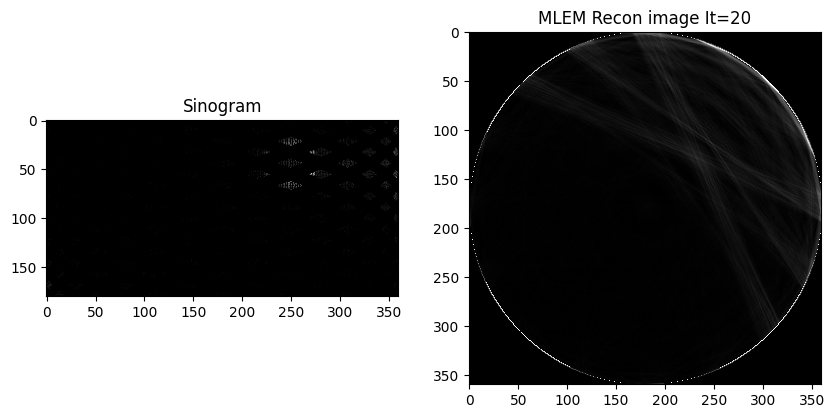

In [13]:
from skimage.draw import disk

sinogram, theta_centers = compute_sinogram(coincidences_df, bins_theta=360, bins_r=180, use_tof=True)

image_shape = (360, 360)
azi_angles = theta_centers

fig, axs = plt.subplots(1,2, figsize=(10,5))

#axs[0].imshow(true_object, cmap="Greys_r")
#axs[0].set_title('Object')

axs[0].imshow(sinogram.T, cmap="Greys_r") #transpose of sinogram so angle is on y-axis
axs[0].set_title("Sinogram")

#Define reconstructed image
mlem_rec = np.ones(image_shape) #(x^k), iteration 0 (k=0)
mask = np.zeros(image_shape, dtype=bool)
rr, cc = disk((image_shape[0] // 2, image_shape[1] // 2), image_shape[0] // 2)
mask[rr, cc] = True
mlem_rec *= mask
sino_ones = np.ones(sinogram.shape)
sens_image = iradon(sino_ones, azi_angles, circle=True, filter_name=None)

for iter in range(20):  
    fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
    ratio = sinogram / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
    correction = iradon(ratio, azi_angles, circle=True, filter_name=None) / sens_image # No filter because we are just getting the transpose A^T

    axs[1].imshow(mlem_rec, cmap="Greys_r")
    axs[1].set_title("MLEM recon")

    #axs[1, 1].imshow(fp.T, cmap="Greys_r")
    #axs[1, 1].set_title("FP of recon")

    #axs[0, 2].imshow(ratio.T, cmap="Greys_r")
    #axs[0, 2].set_title("Ratio Sinogram")

    #axs[1, 2].imshow(correction, cmap="Greys_r")
    #axs[1, 2].set_title("BP of ratio")

    mlem_rec = mlem_rec * correction

    axs[1].imshow(mlem_rec, cmap="Greys_r")
    axs[1].set_title("MLEM Recon image It=%d" % (iter+1))
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)
